In [81]:
#importing libraries
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization,add
from keras.optimizers import Adam, RMSprop
#from keras.layers import Bidirectional
#from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
#load doc into memory
def load_doc(filename):
    #Opening file for read only
    file1 = open(filename, 'r')
    #read all text
    text = file1.read()
    #close the file
    file1.close()
def load_doc(filename):
    with open(filename, 'r') as f:
        text = f.read()
    return text

filename = r"/content/drive/MyDrive/image_classification/text_file/token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1111_001.jpg#0     A stylish black man in a black hoodie , immersed in his music with a headset .
1111_001.jpg#1	   A young man with a headset and a cool black hoodie .
1111_001.jpg#2	   A black man with a headset and a sleek black hoodie .
1111_001.jpg#3	   A man in a black hoodie enjoys his music 


In [84]:
#Loading descriptions with above doc file
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
            # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
            # store description
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 1255 


In [85]:
# list of descriptions keys
list(descriptions.keys())[:5]

['1111_001', '1111_002', '1111_003', '1111_004', '1111_005']

In [86]:
# descriptions for particular key
descriptions['1111_003']

['A joyful lady beams with a heartwarming smile .',
 'A woman graces the scene in a white top , her smile lighting up the moment .',
 'A lady in a white top exudes happiness .',
 'A white top and a captivating smile .',
 "In her white attire , a cheerful lady's smile is a ray of sunshine ."]

In [87]:
# We're doing the same as we done in above cell
descriptions['1111_200']

['A joyful couple , both wearing wedding rings, pose together for a picture .',
 'A man and a woman , dressed elegantly , proudly display their wedding rings .',
 'A couple in celebration , capturing their love and commitment in a single frame .',
 'The happiness of a newlywed couple showcased through their rings and radiant smiles .',
 'A special moment captured , with a couple proudly displaying their wedding rings .']

In [88]:
# Cleaning above descriptions
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [89]:
# descriptions for particular key
descriptions['1111_003']

['joyful lady beams with heartwarming smile',
 'woman graces the scene in white top her smile lighting up the moment',
 'lady in white top exudes happiness',
 'white top and captivating smile',
 'in her white attire cheerful ladys smile is ray of sunshine']

In [90]:
# We're doing the same as we done in above cell
descriptions['1111_200']

['joyful couple both wearing wedding rings pose together for picture',
 'man and woman dressed elegantly proudly display their wedding rings',
 'couple in celebration capturing their love and commitment in single frame',
 'the happiness of newlywed couple showcased through their rings and radiant smiles',
 'special moment captured with couple proudly displaying their wedding rings']

In [91]:
# converting those loaded description into vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 4367


In [92]:
# We are saving descriptions one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file1 = open(filename, 'w')
    file1.write(data)
    file1.close()

save_descriptions(descriptions, 'descriptions.txt')

In [93]:
# loading  the pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = r'/content/drive/MyDrive/image_classification/text_file/train.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 1004


In [94]:
# Below path contains all the images
images = r'/content/drive/MyDrive/image_classification/peskid_image_data/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [95]:
# Below path contains all name of images which is to be used as train data
train_images_file = r'/content/drive/MyDrive/image_classification/text_file/train.txt'
# Reading the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train image

In [96]:
# Below path contains all name of images which is used to be as test data
test_images_file = r'/content/drive/MyDrive/image_classification/text_file/test.txt'
# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [97]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=1004


In [98]:
# We're converting our image size 299x299
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [99]:
# Loaded the InceptionV3 model here
model = InceptionV3(weights='imagenet')

In [100]:
# Creating a new model, by removing the last layer(output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [101]:
model_new.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 149, 149, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 149, 149, 32)         96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_28

In [102]:
#for layer in inception_model.layers:
    #layer.trainable=False

In [103]:
#read on activation functions
#X = Flatten()(inception_model.output)
#X =Dense(units=3, activation = 'sigmoid')(X)

In [104]:
#model = Model(inception_model.input, X)

#compile model
#model.compile(optimizer='adam',loss= keras.losses.categorical_crossentropy, metrics=['accuracy'])

#summary
#model.summary()

In [106]:
#datagen = ImageDataGenerator(featurewise_center = True, rotation_range=0.4,
                                  #width_shift_range=0.3,
                                  #horizontal_flip=True,
                                  #preprocessing_function= preprocess_input,
                                  #zoom_range=0.4,
                                  #shear_range = 0.4)

In [107]:
#train_data = datagen.flow_from_directory(directory='/content/drive/MyDrive/ora/train',
                                              #target_size=(256,256),
                                              #batch_size=32)

In [108]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#mc = ModelCheckpoint(filepath='/content/drive/MyDrive/image_classification/INCEPTION_model.h5',
                  #monitor = 'accuracy',
                  #verbose=1,
                  #save_best_only=True)
#es= EarlyStopping(monitor='accuracy',
                 #min_delta=0.01,
                 #patience=15,
                 #verbose=1)

#cb=[mc,es]

In [110]:
#his = model.fit_generator(train_data,
                          #steps_per_epoch=56,
                          #epochs=50,
                          #validation_data=val_data,
                          #callbacks=cb)

In [111]:
from keras.models import load_model

#model = load_model('/content/drive/MyDrive/')

In [112]:
# Function to encode a given image into a vector of size (2048, )
#def encode(image):
    #image = preprocess(image) # preprocess the image
    #fea_vec = model_new.predict(image) # Get the encoding vector for the image
    #fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    #return fea_vec

In [113]:
# We're Calling the above funtion to encode all the train images
# This will take a while on CPU - Execute this only once
#start = time()
#encoding_train = {}
#for img in train_img:
#    encoding_train[img[len(images):]] = encode(img)
#print("Time taken in seconds =", time()-start)

In [114]:
import pickle
#Save this encoded_train pkl files for training features to the disk
#with open("/content/drive/MyDrive/image_classification/encoded_train_images.pkl", "wb") as encoded_pickle:
   # pickle.dump(encoding_train, encoded_pickle)

In [115]:

# We're Calling the above funtion to encode all the test images - Execute this only once
#start = time()
#encoding_test = {}
#for img in test_img:
#    encoding_test[img[len(images):]] = encode(img)
#print("Time taken in seconds =", time()-start)

In [116]:
 #Save the encoded_test pkl file for testing purposes to disk
#with open("/content/drive/MyDrive/image_classification/encoded_test_images.pkl", "wb") as encoded_pickle:
    #pickle.dump(encoding_test, encoded_pickle)

In [117]:
#Let's check how many images we're taking for training
train_features = load(open("/content/drive/MyDrive/image_classification/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=1004


In [118]:
# We're creating here a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

5020

In [119]:
# Considering only those words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 3933 -> 627


In [120]:
# Here we created two dictionaries
ixtoword = {} #index to word
wordtoix = {} #word to index

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [121]:
vocab_size = len(ixtoword) + 1 #one for appended 0's
vocab_size

628

In [122]:
# converting a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculating the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 29


In [123]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [124]:
# Load Glove vectors(You need to download 'glove.6B.200d.txt')
glove_dir = '/content/drive/MyDrive/image_classification/glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [125]:
embedding_dim = 200

# Get 200-dimension dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [126]:
embedding_matrix.shape

(628, 200)

In [127]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [128]:
#summary of the model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 29)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 29, 200)              125600    ['input_6[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_5[0][0]']             
                                                                                            

In [129]:
model.layers[2]

In [131]:
#We set weights for layers here
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [130]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [132]:
#epochs = 150
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [133]:
#for i in range(epochs):
#generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
#history = model.fit_generator(generator, epochs=150, steps_per_epoch=steps, verbose=1)
#model.save('/content/drive/MyDrive/image_classification/model_weights/model_' + str(i) + '.h5')

In [159]:
# Loading that last saved model from your model_weights folder
model.load_weights('/content/drive/MyDrive/image_classification/model_weights/model_627.h5')

In [160]:
images = '/content/drive/MyDrive/image_classification/image_data/'

In [161]:
# We're opening those encoded_text pkl file for testing
with open("/content/drive/MyDrive/image_classification/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [162]:
def imageSearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

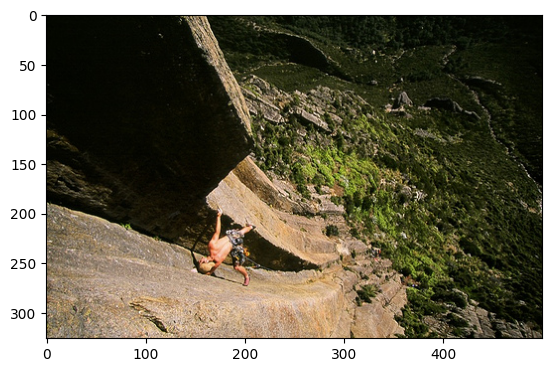

Image with Caption: man in red shirt is climbing rock wall


In [164]:
# Your result
pic = list(encoding_test.keys())[34]
image = encoding_test[pic].reshape((1, 2048))
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print("Image with Caption:",imageSearch(image))